# Fixture Modelling

How many goals are PL teams to score and concede in upcoming fixtures?

See here for some more technical details http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf

## Setup

In [96]:
import pandas as pd
from datetime import timezone
import numpy as np
from collections import defaultdict
import scipy.stats
import scipy.optimize
import seaborn as sns

clone FPL repo and update path below

    git clone https://github.com/vaastav/Fantasy-Premier-League

pull latest updates

In [2]:
FPL_PATH = '~/personal/Fantasy-Premier-League'

In [3]:
!cd ~/personal/Fantasy-Premier-League && git pull

fatal: unable to access 'https://github.com/vaastav/Fantasy-Premier-League/': Could not resolve host: github.com


## Load data

In [4]:
SEASONS = ['2018-19' ,'2019-20','2020-21', '2021-22',]

In [5]:
combined = pd.DataFrame()
for season in SEASONS:
    df = pd.read_csv(f'{FPL_PATH}/data/{season}/fixtures.csv',parse_dates=['kickoff_time'])
    df['season'] = season
    combined = df.append(combined)

In [6]:
teams = pd.read_csv(f'{FPL_PATH}/data/master_team_list.csv')

the numbers aren't consistent across seasons so we merge on names and come up with our own numbering

In [7]:
def clean_names(combined, teams):    
    with_names = combined.copy()
    for suff in ['_h','_a']:
        with_names = with_names.merge(teams.rename(columns={'team':f"team{suff}",
                                                            "team_name":f'team_name{suff}'}),on = ['season',f'team{suff}'],how='left')
    unique_teams = list(set(with_names["team_name_h"]))
    name_mapping = dict(zip(unique_teams,range(len(unique_teams))))
    with_names['team_h'] = with_names.team_name_h.map(name_mapping) 
    with_names['team_a'] = with_names.team_name_a.map(name_mapping)
    with_names['days_since_fixture'] = (pd.Timestamp.utcnow() - with_names['kickoff_time']).dt.days
    return with_names, name_mapping

In [178]:
df, name_mapping = clean_names(combined, teams)

In [9]:
COLS = ['team_h','team_a','days_since_fixture','team_h_score','team_a_score']

In [10]:
results = df.loc[(df.finished),COLS].copy()
fixtures = df.loc[~df.finished,COLS].copy() 

In [11]:
assert with_names['team_name_h'].isna().sum() == 0

## Fit model - (1) Dixon-Coles like

We model a game with home/away score (x,y) as being

$\lambda_h = exp(\mu + \gamma + \alpha_{ha} - \alpha_{ad})$

$\lambda_a = exp(\gamma + \alpha_{aa} - \alpha_{hd})$

$p(x,y) = \frac{exp(-\lambda_h)(\lambda_h)^x}{x!} \frac{exp(-\lambda_a)(\lambda_a)^y}{y!}$

Each team has a coefficient for attacking/defending, and there is a fixed effect $\gamma$ and a home-team fixed effect $\mu$. 

In [12]:
def neg_log_likehihood(params, df, discount, n_teams):
    '''
    Based on model above, sum the negative log likelihood, discounted by time
    '''
    mu, gamma, *alpha  = params
    alpha_score = alpha[:n_teams]
    alpha_concede = alpha[n_teams:]
    home = mu +gamma + np.take(alpha_score,df.team_h) - np.take(alpha_concede,df.team_a)
    away = gamma + np.take(alpha_score,df.team_a) - np.take(alpha_concede,df.team_h)
    exp_home = np.exp(home)
    exp_away = np.exp(away)
    neg_log_lik = exp_home - (df["team_h_score"] * home) + exp_away - (df["team_a_score"] * away)
    loss = (np.exp(-discount * df["days_since_fixture"]) * neg_log_lik).sum()
    return loss / df.shape[0]

In [13]:
class DixonColes():
    def __init__(self, name_mapping, discount = 0.01):
        self.name_mapping = name_mapping
        self.n_teams = len(name_mapping)
        self.discount = discount 
        self.params = [0.0 for _ in range(2 + (2*self.n_teams))]
    
    def fit(self, X): 
        '''
        Minimise negative log-likelihood
        '''
        res = scipy.optimize.minimize(
            fun=neg_log_likehihood,
            x0=self.params,
            args=(X, self.discount, self.n_teams),
        )
        mu, gamma, *alpha = res['x']
        alpha_score = alpha[:self.n_teams]
        alpha_concede = alpha[self.n_teams:]
        return mu, gamma, alpha_score, alpha_concede
        


In [14]:
mu, gamma, alpha_score, alpha_concede =  DixonColes(name_mapping).fit(results)

mu tells us how much of a home advantage there is

In [15]:
mu

0.15180319489715235

In [16]:
form = pd.DataFrame(data=[name_mapping.keys(),alpha_score, alpha_concede]).T
form.columns = ['team', 'attack','defence']

In [17]:
form['total'] = form.attack + form.defence

This seams like a reasonable form ranking. I think the model is overrating Brentford a bit having never seen them before.

In [18]:
(form
 .iloc[list(set(fixtures.team_h))]
 .sort_values(by='total',ascending=False))

,team,attack,defence,total
22,Man City,0.63004,0.706299,1.33634
3,Chelsea,0.520065,0.746425,1.26649
25,Liverpool,0.681984,0.309578,0.991562
18,Brentford,0.448915,0.382639,0.831554
19,Man Utd,0.43989,0.24979,0.68968
9,West Ham,0.40653,-0.0325216,0.374008
12,Aston Villa,0.204831,0.116339,0.321171
8,Brighton,-0.125064,0.384513,0.25945
21,Everton,0.195894,0.00309217,0.198986
13,Arsenal,0.0586539,0.129134,0.187788


## Fit Model (2) - ELO

In [19]:
results['outcome'] =np.clip(results['team_h_score'] -results['team_a_score'],-1,1)

In [117]:
class Elo:
    def __init__(
        self,
        results,
        k_factor=35
    ):
        self.fixtures = results.copy().reset_index(drop=True)
        self.ratings =defaultdict(lambda: 1200)
        self.k_factor = k_factor
 
    def _record_expectation(self, i, fixture):
        self.fixtures.at[i, "elo_e"] = self.win_prob(fixture['team_h'], fixture['team_a'])
        self.fixtures.at[i, "elo"] = self.ratings[fixture['team_h']]


    def process_all_fixtures(self):
        for i, f in self.fixtures.iterrows():
            self._record_expectation(i, f)
            self._process_fixture(f)
        return self.fixtures, self.ratings

    def _process_fixture(self, fixture):
        win_prob = self.win_prob(fixture['team_h'], fixture['team_a'])
        self.ratings[fixture['team_h']] += (
            (fixture['outcome'] - win_prob) * self.k_factor
        )
        self.ratings[fixture['team_a']] += (
            (win_prob - fixture['outcome']) * self.k_factor
        )

    def win_prob(self, team_1, team_2):
        rating_1, rating_2 = self.ratings[team_1], self.ratings[team_2]
        q1 = 10.0 ** (rating_1 / 400)
        q2 = 10.0 ** (rating_2 / 400)
        return q1 / (q1 + q2)

In [118]:
results = results.sort_values(by='days_since_fixture',ascending=False)

In [119]:
elo =Elo(results)
historic_elo, elo_ratings =elo.process_all_fixtures()

## Plot elo over time

In [157]:
inv_mapping = {v:k for k,v in name_mapping.items()}

In [158]:
historic_elo['name'] = historic_elo.team_h.map(inv_mapping)

In [159]:
historic_elo['neg_days_since_fixture'] = historic_elo['days_since_fixture'] * -1

In [160]:
filtered = historic_elo.loc[historic_elo.name.isin(['Chelsea', 'Man City', 'Liverpool','West Ham', 'Man Utd'])]

<AxesSubplot:xlabel='neg_days_since_fixture', ylabel='elo'>

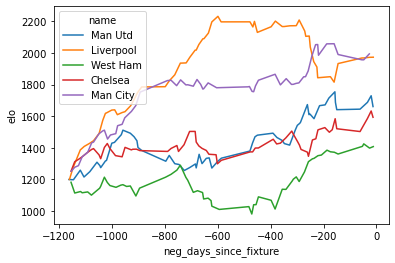

In [161]:
sns.lineplot(data=filtered, hue='name', y='elo', x='neg_days_since_fixture')

In [162]:
form['elo'] =pd.Series(elo_ratings).sort_index()

In [163]:
form.iloc[list(set(fixtures.team_h))].sort_values(by='total',ascending=False).style.background_gradient(cmap='Blues')

,team,attack,defence,total,elo
22,Man City,0.630040,0.706299,1.336339,2014.797909
3,Chelsea,0.520065,0.746425,1.266490,1594.658153
25,Liverpool,0.681984,0.309578,0.991562,1956.628896
18,Brentford,0.448915,0.382639,0.831554,1302.779410
19,Man Utd,0.439890,0.249790,0.689680,1630.277080
9,West Ham,0.406530,-0.032522,0.374008,1347.654159
12,Aston Villa,0.204831,0.116339,0.321171,1257.569050
8,Brighton,-0.125064,0.384513,0.259450,1220.823699
21,Everton,0.195894,0.003092,0.198986,1355.844650
13,Arsenal,0.058654,0.129134,0.187788,1427.625895


## Map form onto fixtures

In [164]:
CURRENT_GAMEWEEK = 7 # I should probably calculate this from fixtures

map on the expected scoring rates

In [185]:
fixtures['score'] = np.exp(mu +gamma + np.take(alpha_score,fixtures.team_h) - np.take(alpha_concede,fixtures.team_a))
fixtures['opp_score'] = np.exp(gamma + np.take(alpha_score,fixtures.team_a) - np.take(alpha_concede,fixtures.team_h))

In [186]:
fixtures['elo_win'] =fixtures.apply(lambda row: elo.win_prob(row['team_h'],row['team_a']),axis=1)

In [187]:
fixtures['team'] = fixtures['team_h'].map(inv_mapping)
fixtures['opp'] = fixtures['team_a'].map(inv_mapping)

We flip home and away fixtures to have all fixtures for all teams in long format

In [188]:
upcoming_difficulties = fixtures[['team','opp','score','elo_win','opp_score','days_since_fixture']]

In [189]:
flipped_difficulties = upcoming_difficulties.copy().rename(columns={'team':'opp',
                                                                    'opp':'team',
                                                                    'score':'opp_score',
                                                                    'opp_score':'score',})
flipped_difficulties['elo_win'] = 1 -flipped_difficulties['elo_win']

In [190]:
assert (upcoming_difficulties.groupby('team')['opp'].count() + upcoming_difficulties.groupby('opp')['team'].count()).max() == 38 - CURRENT_GAMEWEEK

In [191]:
combined_difficulties = upcoming_difficulties.append(flipped_difficulties)

In [192]:
combined_difficulties['gw'] = combined_difficulties.reset_index().sort_values(by='days_since_fixture').groupby('team').days_since_fixture.cumcount() +1 + CURRENT_GAMEWEEK

In [193]:
score_pivot = pd.pivot_table(data=combined_difficulties,values='score',
                             index='team',columns='gw')

In [194]:
defend_pivot = pd.pivot_table(data=combined_difficulties,values='opp_score',
                              index='team',columns='gw')

In [195]:
elo_pivot = pd.pivot_table(data=combined_difficulties,values='elo_win',
                              index='team',columns='gw')

Filter the data for the next n weeks

In [196]:
N = 5

In [197]:
for outcome in ['score','opp_score','elo_win']:
    print(outcome)
    pivot = pd.pivot_table(data=combined_difficulties,values=outcome,
                             index='team',columns='gw')
    n_week = pivot.iloc[:,:N].copy()
    n_week['avg'] = n_week.mean(axis=1)
    display(n_week
     .sort_values(by='avg',ascending=False) 
     .style.background_gradient(cmap='Blues'))

score


gw,8,9,10,11,12,avg
team,,,,,,
Chelsea,1.391632,2.702986,3.203414,2.161138,2.815061,2.454846
Brentford,0.773939,2.252479,2.342664,2.517352,2.983413,2.173970
Liverpool,3.235710,1.868704,1.403149,2.478261,1.811397,2.159444
Man City,2.412372,1.550501,2.201247,1.774114,1.950715,1.977790
Man Utd,2.598174,1.187155,2.153624,0.798387,2.539975,1.855463
West Ham,1.815732,1.789594,1.621322,1.148205,1.509783,1.576927
Spurs,2.340642,1.540097,0.997733,1.486214,1.476755,1.568288
Leeds,1.378643,0.897471,1.943108,1.493779,1.441170,1.430834
Arsenal,1.243137,0.983697,1.774597,1.490505,0.943770,1.287141


opp_score


gw,8,9,10,11,12,avg
team,,,,,,
Newcastle,2.340642,1.731867,3.203414,1.443810,2.983413,2.340629
Leicester,2.598174,2.252479,1.774597,1.493779,2.815061,2.186818
Norwich,1.650424,2.702986,1.943108,2.517352,1.552704,2.073315
Watford,3.235710,1.709764,1.358208,1.490505,2.539975,2.066832
Burnley,2.412372,1.066596,2.342664,2.161138,1.582846,1.913123
Spurs,1.313101,1.789594,2.153624,1.449695,1.441170,1.629437
West Ham,1.309524,1.540097,1.321280,2.478261,0.730435,1.475919
Everton,1.815732,0.911098,0.704879,1.486214,1.950715,1.373728
Crystal Palace,1.243137,1.503386,2.201247,0.925799,0.808686,1.336451


elo_win


gw,8,9,10,11,12,avg
team,,,,,,
Man City,0.997694,0.989753,0.995156,0.901453,0.977974,0.972406
Liverpool,0.996666,0.867454,0.985736,0.970845,0.954574,0.955055
Chelsea,0.842930,0.995370,0.953105,0.974703,0.838627,0.920947
Brentford,0.157070,0.491964,0.877746,0.975645,0.791108,0.658707
Arsenal,0.874922,0.726895,0.665194,0.934324,0.045426,0.649352
Leeds,0.785806,0.682433,0.970046,0.439099,0.362512,0.647979
Man Utd,0.864489,0.132546,0.822507,0.098547,0.978577,0.579333
Everton,0.511785,0.903949,0.782980,0.488418,0.022026,0.541832
Spurs,0.843357,0.523354,0.177493,0.511582,0.637488,0.538655
